In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
import unicodedata as ud

import os, re

DATA_DIR = "current_project"
PRICES_FNAME = "stocks_weekly.csv"
ESTIMATES_FMASK = "estimates_sales_{}.csv"
OUTPUT_DIR = "data_ip"
START_YEAR = 2013
END_YEAR = 2020
MIN_DATA_POINTS = 50



In [2]:

regex = re.compile("[^0-9a-zA-Z_-]")

def brief_ticker(s):
    # make ticker be appropriate as a file name
    return regex.sub('_', unidecode(str(s.encode(), encoding="utf-8"))).replace("_US_Equity", "").strip("_")

def skip_ticker(s):
    return s == "" or s.startswith("2017Y") or s.startswith("Unnamed") or s.endswith("_1")

def filter_table(data, tickers=None):
    # remove duplicated columns
    if sum(data.columns.duplicated()) > 0:
        print("Warning: duplicated columns in file '{}', will be removed".format(fname))
        data = data.loc[:,~data.columns.duplicated()]
    # use brief ticker names
    new_names = {col: brief_ticker(col) for col in data.columns}
    data.rename(columns=new_names, inplace=True)
    # check duplicated columns after renaming
    if sum(data.columns.duplicated()) > 0:
        raise Exception("Duplicated columns in file '{}' after renaming".format(fname))
    # skip garbage columns
    data = data[[col for col in data.columns if not skip_ticker(col)]]
    # leave only needed tickers
    if tickers is not None:
        cols = [col for col in data.columns if col in tickers]
        data = data[cols]
    # sort by dates
    data.sort_index(inplace=True)
    return data

def load_estimates(fname, start_dt, end_dt, use_ud):
    data = pd.read_csv(fname, skiprows=[0,1,2,3,5,6], index_col=0, parse_dates={"Date": [0]}, dayfirst=True)
    # leave only needed dates
    data = data[(data.index >= start_dt) & (data.index <= end_dt)]
    # decode, remove decimal spaces
    data = data.astype(str)
    if use_ud:
        data = data.applymap(lambda s: ud.normalize("NFKD", s).encode("ascii", "ignore").decode())
    else:
        data = data.applymap(lambda s: unidecode(str(s.encode(), encoding="utf-8")))
    # convert to float
    data = data.applymap(lambda s: s.replace(' ', ''))
    data = data.apply(lambda col: pd.to_numeric(col, downcast="float", errors="coerce"))
    return filter_table(data)

def load_all_estimates(use_ud=False):
    all_data = None
    for year in range(START_YEAR, END_YEAR + 1):
        print("Processing {} ...".format(year))
        start_dt = pd.Timestamp(year, 1, 1)
        end_dt = pd.Timestamp(year, 12, 31)
        fname = os.path.join(DATA_DIR, ESTIMATES_FMASK.format(year))
        data = load_estimates(fname, start_dt, end_dt, use_ud)
        if all_data is None:
            all_data = data
        else:
            all_data = all_data.append(data)
    return all_data

def load_prices(tickers):
    fname = os.path.join(DATA_DIR, PRICES_FNAME)
    data = pd.read_csv(fname, skiprows=[0,1,2,4,5], index_col=0, parse_dates={"Date": [0]}, dayfirst=True, sep=';')
    # leave only needed dates
    start_dt = pd.Timestamp(START_YEAR, 1, 1)
    end_dt = pd.Timestamp(END_YEAR, 12, 31)
    data = data[(data.index >= start_dt) & (data.index <= end_dt)]
    return filter_table(data, tickers)

def save_to_files(data, out_dir):
    with open(os.path.join(out_dir, "tickers.lst"), "w") as f:
        for tk in sorted(data.columns):
            if skip_ticker(tk):
                continue
            tkd = data[tk].dropna().drop_duplicates()
            if tkd.shape[0] < MIN_DATA_POINTS:
                continue
            f.write("{}\n".format(tk))
            fname = os.path.join(out_dir, tk + ".txt")
            tkd.to_csv(fname, sep=' ', header=False, date_format="%Y-%m-%d")


In [3]:
# load all estimates
estimates = load_all_estimates()

Processing 2013 ...
Processing 2014 ...
Processing 2015 ...
Processing 2016 ...
Processing 2017 ...
Processing 2018 ...
Processing 2019 ...
Processing 2020 ...


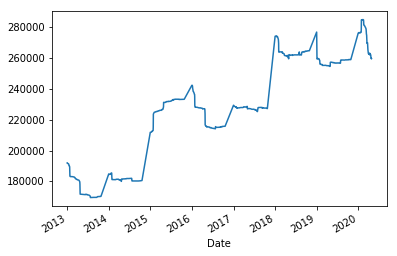

In [4]:
estimates["AAPL"].dropna().drop_duplicates().plot()

In [5]:
# load stock prices
prices = load_prices(estimates.columns)
prices.head(5)

AAPL      ACN    ADBE      ADP  ALLE      AMD      AME     AMT  \
Date                                                                           
2013-01-04  75.966  78.6041  38.190  64.6211   NaN  21582.0  41.2120  78.523   
2013-01-11  75.000  79.3880  38.149  64.9297   NaN  24504.0  41.0531  80.286   
2013-01-18  72.074  79.6493  38.039  65.2575   NaN  16834.0  41.6779  80.867   
2013-01-25  63.408  82.0350  38.380  65.4432   NaN  31079.0  43.4886  81.427   
2013-02-01  65.389  83.8414  38.400  66.2737   NaN  43984.0  43.9121  78.115   

             ANSS      APO  ...      VFC   VRSK     VRSN      WCN   WDAY  \
Date                        ...                                            
2013-01-04  70.50  21.1633  ...  46.1988  53.50  47.0198  49.5292  52.19   
2013-01-11  72.83  22.3197  ...  44.7541  53.90  44.6242  49.2789  52.79   
2013-01-18  73.08  24.2279  ...  44.4357  54.58  46.4444  49.3699  50.39   
2013-01-25  73.52  24.5864  ...  44.7450  54.99  50.4488  50.3259  54.39   
2013-02-01  74.42  26.3326  ...  44.4146  55.71  52.0694  50.7584  53.52   

                 WM      WST      YNDX     ZBRA      ZTS  
Date                                                      
2013-01-04  46.0010  32.1708     23.24  40.6716      NaN  
2013-01-11  46.9863  31.8700  44188.00  41.3000      NaN  
2013-01-18  47.5803  32.0609     22.86  41.5300      NaN  
2013-01-25  48.1742  34.1329     23.95  42.8600      NaN  
2013-02-01  48.9975  34.7075  44036.00  43.6500  43861.0  

[5 rows x 118 columns]

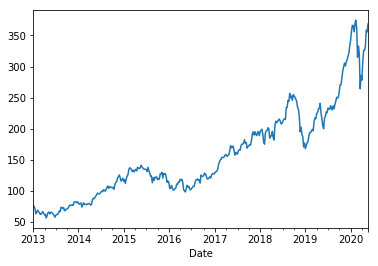

In [6]:
prices['AAPL'].dropna().drop_duplicates().plot()

In [7]:
# prepare dirs
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

estim_dir = os.path.join(OUTPUT_DIR, "estims")
if not os.path.exists(estim_dir):
    os.mkdir(estim_dir)

price_dir = os.path.join(OUTPUT_DIR, "prices")
if not os.path.exists(price_dir):
    os.mkdir(price_dir)

print("Saving estimates ...")
save_to_files(estimates, estim_dir)

print("Saving prices ...")
save_to_files(prices, price_dir)

Saving estimates ...
Saving prices ...
